### ML 데이터 준비

- data__데이터전처리통합.ipynb 아래 코드에서 담당 카테고리의 변경사항 있을시 수정해서 사용

In [1]:
# 라이브러리
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
DATA_PATH = DATA_DIR / "analy_data.csv"
SAVE_FILE = "preprocessed_v1.csv"

# JSON 컬럼 관리 파일 로드
with open("columns.json", "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

# 공통 함수 
def get_columns(*categories):
    """columns.json의 카테고리별 use=y 컬럼 추출"""
    selected = []
    for cat in categories:
        for col, meta in columns_dict[cat].items():
            if meta.get("use", "n") == "y": 
                selected.append(col)
    
    if "churn" not in selected:
        selected.append("churn")

    if "exmprs_no" not in selected:
        selected.append("exmprs_no")

    return selected

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)

# 1. 기본정보 + 가구조사 
def preprocess_basic_house(data_path):
    cols = get_columns("기본정보", "가구조사")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    if "CTPRVN_CODE" in df.columns:
        df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
    if "SPOT_NO" in df.columns:
        df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
    if "sex" in df.columns:
        df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

    # NaN 변경
    for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["fma_13z1", "fma_14z1"]:
        if col in df.columns:
            df.loc[df[col] >= 77777, col] = np.nan

    for col in ["fma_24z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 2. 식생활 + 비만및체중조절 + 구강건강
def preprocess_diet_obesity_oral(data_path):
    cols = get_columns("식생활", "비만및체중조절", "구강건강")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["nua_01z2", "nuc_02z1", "nuc_03z1", "obb_02a1", "obb_02b1", "obb_02d1", "ora_01z1", "orb_01z1", "ord_01d2", "ord_05z1", "ord_01f3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["ore_03z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 3. 음주 + 신체활동
def preprocess_drink_physical(data_path):
    cols = get_columns("음주", "신체활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # 값 변경
    if "drb_01z3" in df.columns:
        df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

    if "drb_03z1" in df.columns:
        df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

    # NaN 변경 
    for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 4. 정신건강 + 보건이용
def preprocess_mental_health(data_path):
    cols = get_columns("정신건강", "보건이용")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경 
    for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["edit_mtc_03z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 5. 건강행태 + 교육및경제활동
def preprocess_behavior_education(data_path):
    cols = get_columns("건강행태", "교육및경제활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
                "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    for col in ["smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
            if col in df.columns:
                df.loc[df[col] >= 777, col] = np.nan
    return df

df_basic = preprocess_basic_house(DATA_PATH)
df_health = preprocess_diet_obesity_oral(DATA_PATH)
df_drink = preprocess_drink_physical(DATA_PATH)
df_mental = preprocess_mental_health(DATA_PATH)
df_behavior = preprocess_behavior_education(DATA_PATH)

dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
df_merge = dfs[0]
for temp in dfs[1:]:
    join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
    if join_cols:
        df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

#=========================
# 추가 전처리
#=========================
# doyeon
#=========================
# '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
df_merge['sex'] = df_merge['sex']
df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# 값변경
df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# 범주형 칼럼 object형 변환
df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

#=========================
# soso
#=========================
# 연령대
df_merge['age_group'] = (df_merge['age'] // 10) * 10

# 1인가구
df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# 월간소득 기준 가구소득컬럼 통합
df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# 치매가족여부
def get_dementia_case(row):
    if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
        return 1 # 치매가족 있음 + 같이 거주
    elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
        return 2 # 치매가족 있음 + 비거주
    elif row['fma_27z1'] == 2:
        return 3 # 치매가족 없음
    else:
        return np.nan

df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)
df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1'], axis=1, inplace=True)
print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

컬럼 식별 완료된 데이터 크기: (89822, 75) -2
결측치 비율: (평균) 26.72%
추가 전처리 후 데이터 크기: (89822, 76) -2
exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용


In [28]:
# 한글컬럼으로 확인할 시 사용
df_merge_kor = rename_to_kor(df_merge)

---

In [3]:
df_merge

,exmprs_no,age,sex,CTPRVN_CODE,SPOT_NO,wt_p,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,churn,nua_01z2,nuc_02z1,nuc_03z1,obb_02a1,obb_02b1,obb_02d1,ora_01z1,orb_01z1,ord_01d2,ord_05z1,ord_01f3,ore_03z2,dra_01z1,drb_01z3,drb_03z1,drg_01z3,pha_04z1,pha_05z1,pha_06z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smb_09z1,sma_36z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_01z1,sob_02z1,soa_01z1,soa_06z2,soa_07z1,sod_02z3,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case
0,2024111170001700102002201,31.000000,1,11,00102,380.470750,1.000000,1.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,3.000000,1.000000,2.000000,1.000000,0.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,888.000000,NaN,NaN,2.000000,0.000000,1.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,5.000000,NaN,30.000000,1,1000.000000,6.908755,8.000000,3.000000
1,2024111170001700102005901,37.000000,1,11,00102,380.470750,3.000000,2.000000,3.000000,NaN,1.000000,0,2.000000,1.000000,1.000000,NaN,NaN,NaN,2.000000,5.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,0.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000,NaN,30.000000,0,300.000000,5.707110,5.000000,3.000000
2,2024111170001700102005902,36.000000,2,11,00102,376.403830,3.000000,2.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,4.000000,2.000000,0.000000,88.000000,88.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,5.000000,0.000000,10.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,6.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000
3,2024111170001700102017001,36.000000,1,11,00102,380.470750,2.000000,2.000000,3.000000,NaN,1.000000,0,4.000000,1.000000,NaN,1.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,0.000000,88.000000,88.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,1.000000,NaN,30.000000,0,667.000000,6.504288,8.000000,3.000000
4,2024111170001700191001801,64.000000,1,11,00191,119.450590,1.000000,1.000000,1.000000,NaN,4.000000,0,2.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,NaN,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,88.000000,88.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,3.000000,3.000000,3.000000,2.000000,NaN,NaN,5.000000,NaN,60.000000,1,50.000000,3.931826,2.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89817,2024503970006201711015701,49.

### 모델에 들어가는 피처 핸들링하고 테스트 해보기 (포맷 고정)

In [4]:
# 위 코드 실행 결과: df_merge
df = df_merge.copy()
df = df.drop(['exmprs_no','wt_p'], axis=1)
df.head()

,age,sex,CTPRVN_CODE,SPOT_NO,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,churn,nua_01z2,nuc_02z1,nuc_03z1,obb_02a1,obb_02b1,obb_02d1,ora_01z1,orb_01z1,ord_01d2,ord_05z1,ord_01f3,ore_03z2,dra_01z1,drb_01z3,drb_03z1,drg_01z3,pha_04z1,pha_05z1,pha_06z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smb_09z1,sma_36z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_01z1,sob_02z1,soa_01z1,soa_06z2,soa_07z1,sod_02z3,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case
0,31.000000,1,11,00102,1.000000,1.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,1.000000,2.000000,2.000000,3.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,3.000000,1.000000,2.000000,1.000000,0.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,888.000000,NaN,NaN,2.000000,0.000000,1.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,5.000000,NaN,30.000000,1,1000.000000,6.908755,8.000000,3.000000
1,37.000000,1,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,0,2.000000,1.000000,1.000000,NaN,NaN,NaN,2.000000,5.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,0.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000,NaN,30.000000,0,300.000000,5.707110,5.000000,3.000000
2,36.000000,2,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,4.000000,2.000000,0.000000,88.000000,88.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,5.000000,0.000000,10.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,6.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000
3,36.000000,1,11,00102,2.000000,2.000000,3.000000,NaN,1.000000,0,4.000000,1.000000,NaN,1.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,0.000000,88.000000,88.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,1.000000,NaN,30.000000,0,667.000000,6.504288,8.000000,3.000000
4,64.000000,1,11,00191,1.000000,1.000000,1.000000,NaN,4.000000,0,2.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,NaN,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,88.000000,88.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,3.000000,3.000000,3.000000,2.000000,NaN,NaN,5.000000,NaN,60.000000,1,50.000000,3.931826,2.000000,3.000000


In [30]:
# 결측치 처리

In [31]:
# 파생 변수 생성

In [32]:
# 인코딩 

In [48]:
# 최종 피처 선택 (예시)
fnl_col = ['age', 'sex', 'CTPRVN_CODE', 'SPOT_NO', 'mbhld_co', 'reside_adult_co',
       'fma_04z1', 'fma_24z2', 'nue_01z1', 'churn', 'nua_01z2', 'nuc_02z1',
       'nuc_03z1', 'obb_02a1', 'obb_02b1', 'obb_02d1', 'ora_01z1', 'orb_01z1',
       'ord_01d2', 'ord_05z1', 'ord_01f3', 'ore_03z2', 'dra_01z1', 'drb_01z3',
       'drb_03z1', 'drg_01z3', 'pha_04z1', 'pha_07z1', 'phb_01z1', 'pha_11z1',
       'mta_01z1', 'mta_02z1', 'edit_mtc_03z1', 'mtc_08z1', 'mtc_12c1',
       'mtc_12h1', 'mtj_05z2', 'mtj_10z1', 'mtj_11z1',
       'sob_01z1', 'sob_02z1', 'soa_01z1',
       'soa_06z2', 'soa_07z1', 'sod_02z3', 'drb_binge_monthly', 'age_group',
       'is_single', 'fma_14z1_add', 'fma_14z1_log', 'fma_14z1_group',
       'fma_dementia_case']

# 제거 컬럼(흡연): 'smf_01z1', 'sma_01z1', 'smb_01z1', 'smb_02z1', 'smb_03z1', 'smb_04z1',
# 'smb_05z1', 'smb_06z1', 'sma_36z1', 'smb_12z1', 'sma_08z1', 'sma_11z2', 'smc_08z2'
# 'smc_09z2', 'smc_10z2'
# ['sma_03z2', 'sma_37z1', 'sma_12z2'] -> 타겟변수 만든 변수
# ['smd_02z3','smd_01z3', 'smb_09z1', 'smb_11z1', 'smb_13z1', 'sma_01z1', ...] 제외 -> 예측하고자 하는 타겟의 정보를 가지고있는 변수
df = df[fnl_col]

(71857, 51) (71857,) (17965, 51) (17965,) 

Accuracy: 0.594711939883106
age                 0.140896
SPOT_NO             0.090721
CTPRVN_CODE         0.046602
fma_14z1_log        0.038384
soa_06z2            0.036459
fma_14z1_add        0.033847
edit_mtc_03z1       0.030858
phb_01z1            0.029641
sod_02z3            0.026505
sob_01z1            0.026197
drb_03z1            0.026126
mtc_08z1            0.025826
orb_01z1            0.024069
drb_01z3            0.023914
mtc_12c1            0.022507
ora_01z1            0.022478
ord_05z1            0.022437
pha_07z1            0.022062
pha_04z1            0.020957
nua_01z2            0.020603
drg_01z3            0.019281
pha_11z1            0.018710
mta_01z1            0.017357
obb_02a1            0.016982
mbhld_co            0.016861
ore_03z2            0.012775
soa_07z1            0.012150
nue_01z1            0.011783
reside_adult_co     0.011557
nuc_02z1            0.011509
fma_14z1_group      0.011127
sob_02z1            0.009229


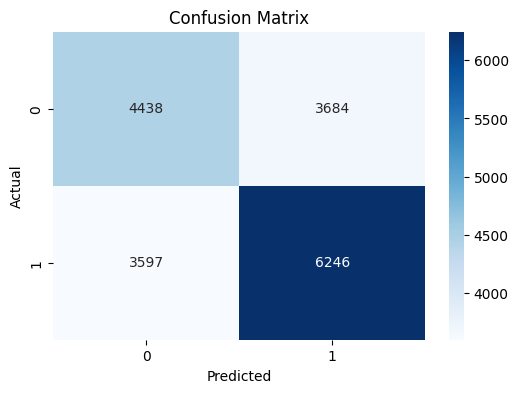

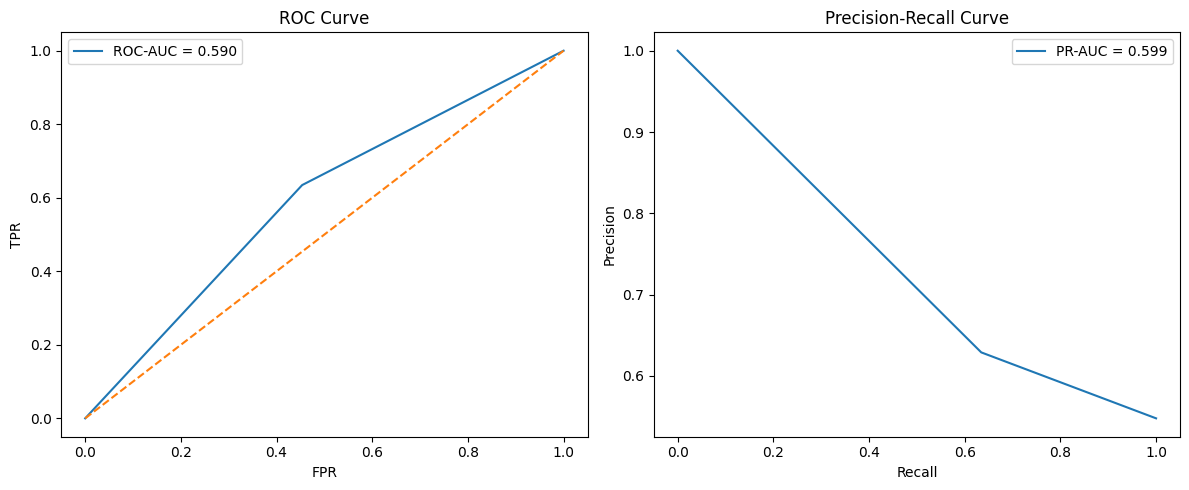

In [49]:
# 모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분리
# df = df_merge.copy()

X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')

# 모델 학습
model = DecisionTreeClassifier(random_state=2)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 변수중요도
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importance.sort_values(ascending=False), '\n')

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()

axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

In [50]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. 데이터 불러오기
# df = pd.read_csv(DATA_PATH)
# 이미 데이터 정의됨

# 2. 데이터 확인
# print("데이터 미리보기:")
# print(df.head(), "\n")


# 문자열 전처리: b'2024' → 2024 형태로 변환
# df = df.applymap(lambda x: str(x).replace("b'", "").replace("'", "") if isinstance(x, str) else x)

# 모든 컬럼을 숫자로 변환 (변환 불가한 건 NaN)
# df = df.apply(pd.to_numeric, errors='coerce')


# 3. 독립변수(X), 종속변수(y) 분리
# 🔹 마지막 컬럼이 타깃(y)이라고 가정합니다. 만약 다르면 수정해주세요.
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]

# 4. 학습용/테스트용 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 5. 랜덤포레스트 모델 학습
rf_clf = RandomForestClassifier(
    random_state=2, 
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,                            )
rf_clf.fit(X_train, y_train)

# 6. 예측
y_pred = rf_clf.predict(X_test)

# 7. 평가지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 8. 결과 출력
print("✅ RandomForestClassifier 평가 결과")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\n세부 분류 리포트:")
print(classification_report(y_test, y_pred))


✅ RandomForestClassifier 평가 결과
Accuracy : 0.6905
Precision: 0.6894
Recall   : 0.6905
F1-Score : 0.6895

세부 분류 리포트:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      8122
           1       0.71      0.74      0.72      9843

    accuracy                           0.69     17965
   macro avg       0.69      0.69      0.69     17965
weighted avg       0.69      0.69      0.69     17965



Confusion matrix (counts):
 [[8106   16]
 [   4 9839]]
Total samples = 17965, errors = 20


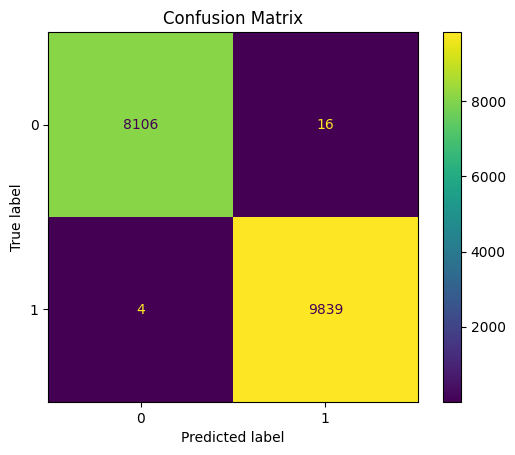

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)   # y_test, y_pred는 이미 있는 변수
print("Confusion matrix (counts):\n", cm)
total = cm.sum()
errors = total - np.trace(cm)
print(f"Total samples = {total}, errors = {errors}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [37]:
# 오분류 샘플확인
test_df = X_test.copy()
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred
mis = test_df[test_df['y_true'] != test_df['y_pred']]
print("오분류 수:", len(mis))
display(mis.head(20))   # 잘못 분류된 샘플을 직접 확인


오분류 수: 20


,exmprs_no,age,sex,CTPRVN_CODE,SPOT_NO,wt_p,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,nua_01z2,nuc_02z1,nuc_03z1,obb_02a1,obb_02b1,obb_02d1,ora_01z1,orb_01z1,ord_01d2,ord_05z1,ord_01f3,ore_03z2,dra_01z1,drb_01z3,drb_03z1,drg_01z3,pha_04z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smb_09z1,sma_36z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_01z1,sob_02z1,soa_01z1,soa_06z2,soa_07z1,sod_02z3,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case,y_true,y_pred
26438,2024413170001221712009001,31.000000,1,41,21712,363.538040,2.000000,2.000000,3.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,4.000000,4.000000,4.000000,1.000000,0.000000,3.000000,2.000000,3.000000,NaN,1.000000,6.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,3.000000,888.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,6.000000,1.000000,1.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,2.000000,1.000000,1.000000,NaN,30.000000,0,1000.000000,6.908755,8.000000,3.000000,1,0
4533,2024111170014937892001804,27.000000,1,11,37892,666.177500,4.000000,4.000000,3.000000,NaN,1.000000,4.000000,1.000000,NaN,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,2.000000,1.000000,NaN,1.000000,3.000000,4.000000,1.000000,0.000000,2.000000,7.000000,1.000000,3.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,0.000000,1.000000,2.000000,2.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,3.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,9.000000,2.000000,5.000000,NaN,20.000000,0,1500.000000,7.313887,8.000000,3.000000,0,1
45823,2024423270009103961000803,26.000000,1,42,03961,44.821120,6.000000,5.000000,3.000000,NaN,1.000000,4.000000,2.000000,NaN,1.000000,2.000000,2.000000,4.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,5.000000,5.000000,2.000000,3.000000,3.000000,7.000000,2.000000,3.000000,NaN,1.000000,NaN,3.000000,2.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,3.000000,0.000000,15.000000,2.000000,1.000000,NaN,NaN,NaN,1.000000,31.000000,1.000000,4.000000,2.000000,NaN,2.000000,7.000000,3.000000,1.000000,3.000000,2.000000,5.000000,NaN,20.000000,0,1500.000000,7.313887,8.000000,3.000000,0,1
33000,2024413170030600711004003,63.000000,1,41,00711,137.761900,3.000000,3.000000,3.000000,NaN,1.000000,1.000000,1.000000,NaN,1.000000,2.000000,2.000000,3.000000,4.000000,1.000000,NaN,1.000000,NaN,1.000000,6.000000,4.000000,1.000000,4.000000,5.000000,4.000000,5.000000,3.000000,NaN,23.000000,4.000000,4.000000,1.000000,2.000000,NaN,2.000000,1.000000,2.000000,888.000000,NaN,NaN,40.000000,0.000000,20.000000,3.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,2.000000,3.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,5.000000,2.000000,1.000000,NaN,60.000000,0,500.000000,6.216606,7.000000,3.000000,0,1
397,2024111170002513981001804,26.000000,1,11,13981,689.452450,4.000000,4.000000,3.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,1.000000,NaN,1.000000,NaN,1.000000,4.000000,5.000000,1.000000,5.000000,5.000000,7.000000,6.000000,2.000000,1.000000,3.000000,NaN,1.000000,3.000000,NaN,NaN,NaN,1.000000,2.000000,888.000000,NaN,NaN,6.000000,0.000000,20.000000,1.000000,2.000000,NaN,NaN,NaN,1.000000,30.000000,2.000000,4.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,8.000000,1.000000,5.000000,NaN,20.000000,0,1000.000000,6.908755,8.000000,3.000000,0,1
4268,2024111170014902992004203,26.000000,1,11,02992,752.713640,5.000000,5.000000,3.000000,NaN,1.000000,3.000000,1.000000,1.000000,NaN,NaN,NaN,4.000000,3.000000,2.000000,4.000000,1.000000,NaN,1.000000,1.000000,-1.000000,NaN,4.000000,4.000000,3.000000,5.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.0000

In [38]:
# train, test 중복여부 확인
# 방법 A: 인덱스 겹침 검사 (간단)
common_idx = set(X_train.index).intersection(set(X_test.index))
print("같은 인덱스가 train/test에 있는 경우 수:", len(common_idx))

# 방법 B: 값 자체가 동일한 행이 train과 test에 있는지 (모든 feature 기준 merge)
common = pd.merge(X_test.reset_index(), X_train.reset_index(), on=list(X.columns), how='inner')
print("train과 test에 동일한 feature 값을 가진 행 수 (완전 중복):", common.shape[0])


같은 인덱스가 train/test에 있는 경우 수:

 0
train과 test에 동일한 feature 값을 가진 행 수 (완전 중복): 0


In [39]:
# target과 강한 상관 관계를 가진 feature확인
df_all = pd.concat([X, y.rename('target')], axis=1)
corrs = df_all.corr()['target'].abs().sort_values(ascending=False)
print(corrs.head(20))   # 타깃과 절대 상관도가 높은 피처 확인


target              1.000000
smd_02z3            0.963292
smb_01z1            0.855602
sma_36z1            0.320324
age                 0.292371
age_group           0.288582
smb_09z1            0.285593
nua_01z2            0.236455
sod_02z3            0.220702
drb_03z1            0.209135
sma_08z1            0.179870
mtc_12c1            0.171120
smc_09z2            0.152989
drb_01z3            0.150691
mtj_11z1            0.145926
smc_10z2            0.135667
sma_01z1            0.135620
edit_mtc_03z1       0.135595
mta_01z1            0.135381
drb_binge_monthly   0.128451
Name: target, dtype: float64


In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 교차검증
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
clf = RandomForestClassifier(random_state=2)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("5-fold CV accuracies:", scores)
print("CV mean:", scores.mean(), "std:", scores.std())
# 랜덤하게 나눈 다른 데이터셋에서도 비슷한 결과를 낼 가능성이 높음


5-fold CV accuracies: [0.99910938 0.99949903 0.999332   0.99927633 0.99922066]
CV mean: 0.9992874793096723 std: 0.00012887361728809024


In [41]:
# feature_importances_
importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(20))

# permutation importance (더 신뢰성 있는 방법)
from sklearn.inspection import permutation_importance
res = permutation_importance(rf_clf, X_test, y_test, n_repeats=10, random_state=2, n_jobs=-1)
perm_imp = pd.Series(res.importances_mean, index=X.columns).sort_values(ascending=False)
print(perm_imp.head(20))


smd_02z3    0.156793
smb_06z1    0.148307
smd_01z3    0.128717
smb_05z1    0.128426
smb_09z1    0.124908
smb_04z1    0.112115
smb_01z1    0.108078
smb_11z1    0.029860
sma_36z1    0.017114
age_group   0.006420
age         0.005379
smb_03z1    0.004614
sma_11z2    0.004384
sma_08z1    0.003882
smb_12z1    0.002932
nua_01z2    0.002737
smb_13z1    0.002310
smb_02z1    0.001946
sod_02z3    0.001718
sma_01z1    0.001394
dtype: float64
smb_11z1          0.008016
sma_36z1          0.003858
smd_02z3          0.000768
smb_13z1          0.000724
smb_12z1          0.000601
sma_08z1          0.000173
smd_01z3          0.000156
sma_11z2          0.000045
exmprs_no         0.000000
smf_01z1          0.000000
mtj_11z1          0.000000
mtj_10z1          0.000000
fma_04z1          0.000000
mbhld_co          0.000000
reside_adult_co   0.000000
CTPRVN_CODE       0.000000
sex               0.000000
fma_24z2          0.000000
nue_01z1          0.000000
nua_01z2          0.000000
dtype: float64


In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
# ROC-AUC
y_prob = rf_clf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)
# ROC-AUC = 1에 매우 근접


ROC AUC: 0.9999761085286223
